# Colônia de Formigas

### Importações de biblioteca

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
from typing import Tuple, List

### Leitura da matriz de distâncias

In [2]:
def read_distance_matrix(path: str) -> np.ndarray:
    """
    Lê a matriz de distâncias a partir de um CSV.
    Espera uma matriz quadrada (20x20).
    """
    df = pd.read_csv(path, header=None)
    mat = df.values.astype(float)
    if mat.shape[0] != mat.shape[1]:
        raise ValueError("A matriz de distâncias precisa ser quadrada.")
    return mat

### Funções complementares ao ACO

Comprimento (custo) de uma rota

In [5]:
def tour_length(tour: np.ndarray, dist_mat: np.ndarray) -> float:
    """
    Comprimento (custo) de um tour (rota) - tour é array de índices das cidades.
    Considera retorno à cidade inicial.
    """
    L = 0.0
    n = len(tour)
    for i in range(n-1):
        L += dist_mat[tour[i], tour[i+1]]
    L += dist_mat[tour[-1], tour[0]]
    return L

Escolhe a próxima cidade a partir da cidade atual, usando probabilidade proporcional a:

`(pheromone[current,j]^alpha) * ((1/dist[current,j])^beta)`

Somente entre as cidades não visitadas

In [4]:
def choose_next_city(current: int, unvisited: np.ndarray, pheromone: np.ndarray, dist_mat: np.ndarray, alpha: float, beta: float) -> int:
    pher = pheromone[current, unvisited] ** alpha
    # evita divisão por zero: se distância for zero (mesma cidade), atribui grande valor de atratividade a zero (mas não deve ocorrer)
    with np.errstate(divide='ignore', invalid='ignore'):
        heuristic = (1.0 / dist_mat[current, unvisited]) ** beta
    heuristic[np.isinf(heuristic)] = 1e12  # caso houve zero
    probs = pher * heuristic
    s = probs.sum()
    if s == 0:
        # fallback: escolha uniforme
        return np.random.choice(unvisited)
    probs = probs / s
    return np.random.choice(unvisited, p=probs)

Construção de uma rota começando em `start` e retornando o array de cidades na ordem visitada

In [6]:
def build_solution(start: int, pheromone: np.ndarray, dist_mat: np.ndarray, alpha: float, beta: float) -> np.ndarray:
    n = dist_mat.shape[0]
    tour = [start]
    unvisited = np.array([i for i in range(n) if i != start], dtype=int)
    current = start
    while unvisited.size > 0:
        nxt = choose_next_city(current, unvisited, pheromone, dist_mat, alpha, beta)
        tour.append(int(nxt))
        # remover nxt de unvisited
        unvisited = unvisited[unvisited != nxt]
        current = int(nxt)
    return np.array(tour, dtype=int)

Atualiza a matriz de feromônio após cada iteração do ACO.
Ela evapora uma fração do feromônio existente (com taxa `rho`) e adiciona novo feromônio nas arestas percorridas pelas formigas, em quantidade inversamente proporcional ao comprimento de suas rotas `(Q / L)`.
Opcionalmente, reforça as arestas do melhor tour global se o elitismo estiver ativado.

In [7]:
def update_pheromone(pheromone: np.ndarray, ants_tours: List[np.ndarray], ants_lengths: List[float], rho: float, Q: float, elitism: bool=False, best_tour=None, elitist_weight: float=1.0) -> np.ndarray:
    """
    Atualiza matriz de feromônio:
    pheromone <- (1 - rho) * pheromone + sum_k (Delta pheromone from ant k)
    Delta pheromone from ant k on edge (i,j) = Q / Lk if ant k used edge (i,j), else 0
    Se elitism=True e best_tour fornecido, adiciona reforço extra nas arestas do best_tour.
    """
    n = pheromone.shape[0]
    # evaporação
    pheromone *= (1.0 - rho)
    # depósito de cada formiga
    for tour, L in zip(ants_tours, ants_lengths):
        deposit = Q / (L + 1e-12)  # evita divisão por zero
        # percorre arestas do tour (incluindo retorno)
        for i in range(len(tour)-1):
            a, b = tour[i], tour[i+1]
            pheromone[a, b] += deposit
            pheromone[b, a] += deposit
        # aresta retorno
        a, b = tour[-1], tour[0]
        pheromone[a, b] += deposit
        pheromone[b, a] += deposit
    # elitismo: reforça o best_tour (melhor desde o início)
    if elitism and best_tour is not None:
        deposit = elitist_weight * Q / (tour_length(best_tour, dist_mat_global) + 1e-12)
        for i in range(len(best_tour)-1):
            a, b = best_tour[i], best_tour[i+1]
            pheromone[a, b] += deposit
            pheromone[b, a] += deposit
        a, b = best_tour[-1], best_tour[0]
        pheromone[a, b] += deposit
        pheromone[b, a] += deposit
    return pheromone

### Ciclo principal de execução do ACO

Executa o ACO e retorna:

- Lista da melhor distância por iteração
- Melhor rota
- Iteração em que convergiu, ou número de iterações total em caso de não convergência

Parâmetros:

`n_ants` → número de formigas na colônia

`n_iterations` → número máximo de iterações

`alpha` → influência do feromônio na escolha da rota

`beta` → influência da distância (heurística)

`rho` → taxa de evaporação do feromônio

`Q` → quantidade total de feromônio depositada por formiga

`initial_pheromone` → valor inicial do feromônio nas arestas

`elitism` → ativa reforço adicional do melhor tour global

`elitist_weight` → intensidade do reforço elitista

`convergence_patience` → número de iterações consecutivas sem melhora para considerar convergência

`seed` → semente aleatória para reprodutibilidade

`verbose` → exibe mensagens detalhadas durante a execução

In [10]:
def run_aco(dist_mat: np.ndarray,
            n_ants: int = 20,
            n_iterations: int = 1000,
            alpha: float = 1.0,
            beta: float = 2.0,
            rho: float = 0.1,
            Q: float = 1.0,
            initial_pheromone: float = 1.0,
            elitism: bool = False,
            elitist_weight: float = 0.0,
            convergence_patience: int = 100,
            seed: int = None,
            verbose: bool = False) -> Tuple[List[float], np.ndarray, int]:

    if seed is not None:
        np.random.seed(seed)

    n = dist_mat.shape[0]
    # inicializa matriz de feromônio com valor constante
    pheromone = np.ones((n, n)) * initial_pheromone
    # garante simetria
    pheromone = (pheromone + pheromone.T) / 2.0

    best_tour_overall = None
    best_length_overall = np.inf
    best_length_history = []
    no_improve_count = 0
    iter_converged_at = n_iterations  # default se não convergir

    for it in range(n_iterations):
        ants_tours = []
        ants_lengths = []

        # cada formiga constrói uma solução
        # opcional: distribuir inícios aleatoriamente
        start_positions = np.random.choice(n, size=n_ants, replace=True)
        for k in range(n_ants):
            start = int(start_positions[k])
            tour = build_solution(start, pheromone, dist_mat, alpha, beta)
            L = tour_length(tour, dist_mat)
            ants_tours.append(tour)
            ants_lengths.append(L)

        # atualiza melhor solução da iteração
        min_idx = int(np.argmin(ants_lengths))
        if ants_lengths[min_idx] < best_length_overall:
            best_length_overall = ants_lengths[min_idx]
            best_tour_overall = ants_tours[min_idx].copy()
            no_improve_count = 0
        else:
            no_improve_count += 1

        best_length_history.append(best_length_overall)

        # atualiza feromônio (evaporação + depósito)
        # nota: função usa variáveis externas para eval de elitismo (usa dist_mat_global). Passamos elitism e best_tour.
        pheromone = update_pheromone(pheromone, ants_tours, ants_lengths, rho, Q, elitism=elitism, best_tour=best_tour_overall, elitist_weight=elitist_weight)

        # evita feromônio muito pequeno ou muito grande
        pheromone = np.clip(pheromone, 1e-12, 1e12)

        # condição de convergência: se melhor não muda por 'convergence_patience' iterações
        if no_improve_count >= convergence_patience:
            iter_converged_at = it - convergence_patience + 1  # primeira iteração do período estável
            if verbose:
                print(f"Convergiu em iteração {iter_converged_at} (estável por {convergence_patience} iterações).")
            # podemos optar por break ou continuar; aqui paramos porque já consideramos convergido
            break

    return best_length_history, best_tour_overall, iter_converged_at

### Experimentações e plot de gráfico

Retorna a iteração onde a solução ficou estável por `patience` iterações. Se não encontrar estabilidade, retorna o tamanho do melhor histórico de convergência

In [11]:
def detect_convergence_iteration(best_history: List[float], patience: int=100) -> int:
    # verifica janelas finais seguidas
    for i in range(len(best_history) - patience + 1):
        window = best_history[i:i+patience]
        # convergência definida como todos os valores idênticos (ou praticamente iguais)
        if max(window) - min(window) < 1e-12:
            return i  # retorna a primeira iteração da janela
    return len(best_history)

Plota o gráfico da melhor distância ao longo das execuções

In [12]:
def plot_best_history(best_history: List[float], title: str = "Melhor distância por iteração", show=True, savepath: str=None):
    plt.figure(figsize=(10,5))
    plt.plot(best_history, lw=1)
    plt.xlabel("Iteração")
    plt.ylabel("Melhor distância (menor até agora)")
    plt.title(title)
    plt.grid(True)
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches='tight')
    if show:
        plt.show()
    plt.close()

Para cada valor em `ants_list`:

- Executa o ACO `runs_per_settings` vezes

- Coleta a iteração de convergência (ou número máximo de iterações se não convergir)

-  Retorna arrays de médias e desvios padrão das iterações de convergência

In [14]:
def experiment_varying_ants(dist_mat: np.ndarray, ants_list: List[int], runs_per_setting: int = 10, **aco_kwargs):
    means = []
    stds = []
    results_all = []

    for n_ants in ants_list:
        iters_to_conv = []
        print(f"Testando n_ants = {n_ants} (execuções={runs_per_setting})")
        for r in range(runs_per_setting):
            seed = int(time.time()*1000) % 2**32  # semente variável
            _, _, iter_conv = run_aco(dist_mat, n_ants=n_ants, seed=seed, **aco_kwargs)
            iters_to_conv.append(iter_conv)
        iters_to_conv = np.array(iters_to_conv, dtype=float)
        means.append(np.mean(iters_to_conv))
        stds.append(np.std(iters_to_conv, ddof=1) if len(iters_to_conv)>1 else 0.0)
        results_all.append(iters_to_conv)
        print(f"  média={means[-1]:.2f}, std={stds[-1]:.2f}")
    return np.array(means), np.array(stds), results_all

Similar a função anterior, mas varia `rho` (taxa de evaporação do feromônio)

Obs: Número padrão de formigas está em `20`

In [15]:
def experiment_varying_evaporation(dist_mat: np.ndarray, rho_list: List[float], runs_per_setting: int = 5, **aco_kwargs):
    means = []
    stds = []
    results_all = []

    for rho in rho_list:
        iters_to_conv = []
        print(f"Testando rho = {rho:.3f} (execuções={runs_per_setting})")
        for r in range(runs_per_setting):
            seed = int(time.time()*1000) % 2**32
            _, _, iter_conv = run_aco(dist_mat, rho=rho, seed=seed, **aco_kwargs)
            iters_to_conv.append(iter_conv)
        iters_to_conv = np.array(iters_to_conv, dtype=float)
        means.append(np.mean(iters_to_conv))
        stds.append(np.std(iters_to_conv, ddof=1) if len(iters_to_conv)>1 else 0.0)
        results_all.append(iters_to_conv)
        print(f"  média={means[-1]:.2f}, std={stds[-1]:.2f}")
    return np.array(means), np.array(stds), results_all

Faz o plot dos gráficos dos experimentos anteriores

In [16]:
def plot_experiment(x_values, means, stds, xlabel: str, title: str, show=True, savepath: str=None):
    plt.figure(figsize=(8,5))
    plt.errorbar(x_values, means, yerr=stds, fmt='-o', capsize=5)
    plt.xlabel(xlabel)
    plt.ylabel("Iterações até convergência (média ± std)")
    plt.title(title)
    plt.grid(True)
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches='tight')
    if show:
        plt.show()
    plt.close()

### Script Principal

Parâmetros

In [17]:
DIST_CSV_PATH = "distancia_matrix.csv"  
MAX_ITER = 2000
ALPHA = 1.0
BETA = 2.0
RHO = 0.1            # taxa de evaporação padrão
Q = 1.0              # quantidade de feromônio depositada proporcional a Q / L
INITIAL_PHER = 1.0
ELITISM = False
ELITIST_WEIGHT = 0.0
CONVERGENCE_PATIENCE = 100  # conforme enunciado: solução converge se permanecer constante por 100 iterações
SEED = 42
VERBOSE = True
N_ANTS_DEFAULT = 20
N_ITERS_DEFAULT = 500  # iterações máximas por execução (suficientes para observar convergência em muitos casos)

Parâmetros experimentais

In [19]:
ants_list = [5, 10, 20, 40, 80]     # variação do número de formigas
ants_runs = 10                      # 10 execuções para cada quantidade de formigas
rho_list = [0.05, 0.1, 0.2, 0.4, 0.8]  # valores de evaporação a testar
rho_runs = 5                        # 5 execuções para cada valor de evaporação

Carrega matriz dist

In [20]:
dist_mat_global = read_distance_matrix(DIST_CSV_PATH)  # global usado por elitism update (nota: variável global)
n_cities = dist_mat_global.shape[0]
print(f"Matriz de distâncias carregada: {n_cities} cidades (shape={dist_mat_global.shape})")

Matriz de distâncias carregada: 20 cidades (shape=(20, 20))


Execução


Executando ACO (execução única de exemplo) para plot da curva de convergência...
Convergiu em iteração 216 (estável por 100 iterações).
Melhor distância final encontrada: 1328.000000
Melhor tour (prefixo): [13  1  4 16 14 18  7 17  3 15] ... (comprimento = 20)
Solução ficou estável (convergência) começando na iteração 215.


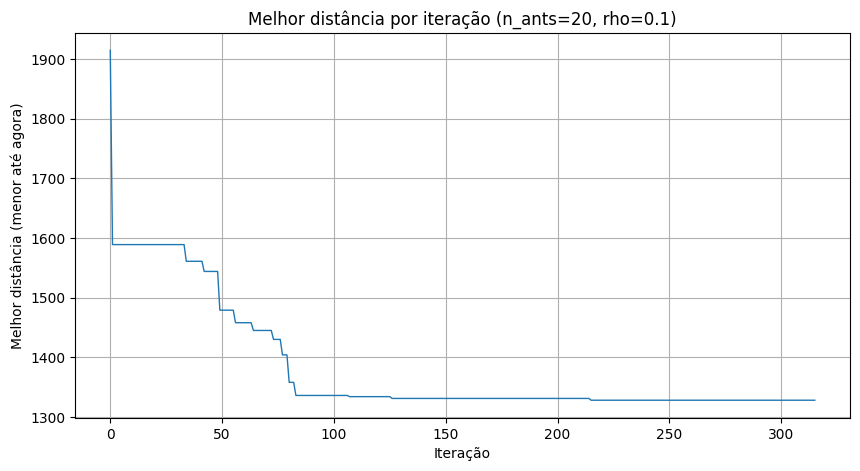

In [21]:
print("\nExecutando ACO (execução única de exemplo) para plot da curva de convergência...")
best_hist, best_tour, iter_conv = run_aco(dist_mat_global,
                                            n_ants=N_ANTS_DEFAULT,
                                            n_iterations=N_ITERS_DEFAULT,
                                            alpha=ALPHA,
                                            beta=BETA,
                                            rho=RHO,
                                            Q=Q,
                                            initial_pheromone=INITIAL_PHER,
                                            elitism=ELITISM,
                                            elitist_weight=ELITIST_WEIGHT,
                                            convergence_patience=CONVERGENCE_PATIENCE,
                                            seed=SEED,
                                            verbose=VERBOSE)
print(f"Melhor distância final encontrada: {best_hist[-1]:.6f}")
if best_tour is not None:
    print(f"Melhor tour (prefixo): {best_tour[:10]} ... (comprimento = {len(best_tour)})")
else:
    print("Nenhum tour salvo (problema inesperado).")

# detecta iteração de convergência (caso não tenha terminado antes)
iter_where_stable = detect_convergence_iteration(best_hist, patience=CONVERGENCE_PATIENCE)
if iter_where_stable < len(best_hist):
    print(f"Solução ficou estável (convergência) começando na iteração {iter_where_stable}.")
else:
    print("Solução não ficou estável (não convergiu dentro das iterações executadas).")

# Plot da melhor distância por iteração
plot_best_history(best_hist, title=f"Melhor distância por iteração (n_ants={N_ANTS_DEFAULT}, rho={RHO})")


Experimento com variação de formigas


=== Experimento: Variando número de formigas ===
Testando n_ants = 5 (execuções=10)
  média=163.20, std=45.31
Testando n_ants = 10 (execuções=10)
  média=173.30, std=57.00
Testando n_ants = 20 (execuções=10)
  média=135.70, std=57.69
Testando n_ants = 40 (execuções=10)
  média=149.20, std=57.99
Testando n_ants = 80 (execuções=10)
  média=95.80, std=38.78


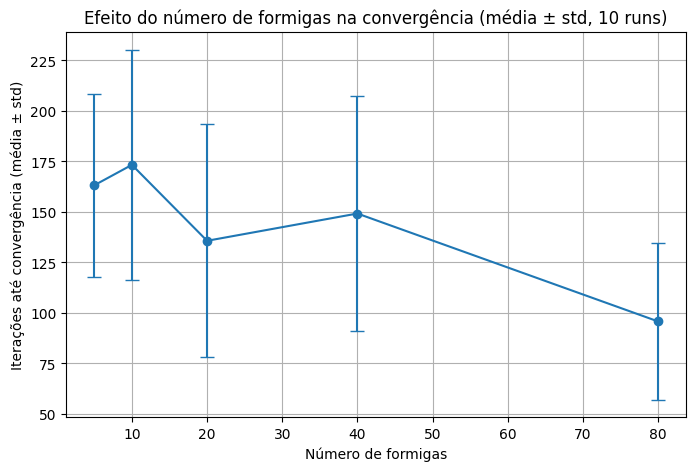

In [22]:
print("\n=== Experimento: Variando número de formigas ===")
mean_iters_ants, std_iters_ants, results_ants = experiment_varying_ants(dist_mat_global,
                                                                        ants_list,
                                                                        runs_per_setting=ants_runs,
                                                                        n_iterations=N_ITERS_DEFAULT,
                                                                        alpha=ALPHA,
                                                                        beta=BETA,
                                                                        rho=RHO,
                                                                        Q=Q,
                                                                        initial_pheromone=INITIAL_PHER,
                                                                        elitism=ELITISM,
                                                                        elitist_weight=ELITIST_WEIGHT,
                                                                        convergence_patience=CONVERGENCE_PATIENCE,
                                                                        verbose=False)

plot_experiment(ants_list, mean_iters_ants, std_iters_ants,
                xlabel="Número de formigas",
                title=f"Efeito do número de formigas na convergência (média ± std, {ants_runs} runs)")


Experimento com variação da evaporação


=== Experimento: Variando taxa de evaporação (rho) ===
Testando rho = 0.050 (execuções=5)
  média=213.40, std=41.64
Testando rho = 0.100 (execuções=5)
  média=176.40, std=78.88
Testando rho = 0.200 (execuções=5)
  média=86.60, std=28.66
Testando rho = 0.400 (execuções=5)
  média=93.60, std=34.07
Testando rho = 0.800 (execuções=5)
  média=78.40, std=34.27


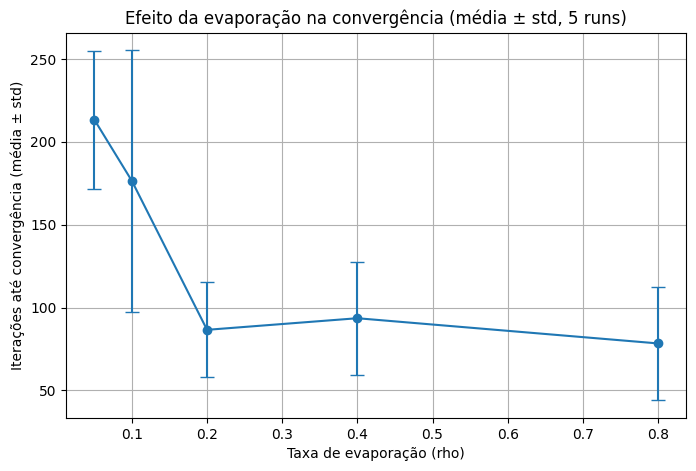

In [28]:
print("\n=== Experimento: Variando taxa de evaporação (rho) ===")
mean_iters_rho, std_iters_rho, results_rho = experiment_varying_evaporation(dist_mat_global,
                                                                                rho_list,
                                                                                runs_per_setting=rho_runs,
                                                                                n_iterations=N_ITERS_DEFAULT,
                                                                                alpha=ALPHA,
                                                                                beta=BETA,
                                                                                Q=Q,
                                                                                initial_pheromone=INITIAL_PHER,
                                                                                elitism=ELITISM,
                                                                                elitist_weight=ELITIST_WEIGHT,
                                                                                convergence_patience=CONVERGENCE_PATIENCE,
                                                                                verbose=False,
                                                                                n_ants=N_ANTS_DEFAULT)

plot_experiment(rho_list, mean_iters_rho, std_iters_rho,
                xlabel="Taxa de evaporação (rho)",
                title=f"Efeito da evaporação na convergência (média ± std, {rho_runs} runs)")

Salvando os resultados e imprimindo um resumo

In [29]:
print("\nResumo dos experimentos:")
print("Ants setting:")
for a, m, s in zip(ants_list, mean_iters_ants, std_iters_ants):
    print(f"  ants={a:3d} -> média iters p/ convergência = {m:.2f} (std={s:.2f})")
print("Evaporation setting:")
for r, m, s in zip(rho_list, mean_iters_rho, std_iters_rho):
    print(f"  rho={r:.3f} -> média iters p/ convergência = {m:.2f} (std={s:.2f})")



Resumo dos experimentos:
Ants setting:
  ants=  5 -> média iters p/ convergência = 163.20 (std=45.31)
  ants= 10 -> média iters p/ convergência = 173.30 (std=57.00)
  ants= 20 -> média iters p/ convergência = 135.70 (std=57.69)
  ants= 40 -> média iters p/ convergência = 149.20 (std=57.99)
  ants= 80 -> média iters p/ convergência = 95.80 (std=38.78)
Evaporation setting:
  rho=0.050 -> média iters p/ convergência = 213.40 (std=41.64)
  rho=0.100 -> média iters p/ convergência = 176.40 (std=78.88)
  rho=0.200 -> média iters p/ convergência = 86.60 (std=28.66)
  rho=0.400 -> média iters p/ convergência = 93.60 (std=34.07)
  rho=0.800 -> média iters p/ convergência = 78.40 (std=34.27)
